In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import corner
import urllib
import os
from sklearn.cross_validation import train_test_split
from astroML.plotting import setup_text_plots

import empiriciSN
from demo_funcs import *

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Instantiate an empiriciSN worker object:
empiricist = empiriciSN.Empiricist()

# Define the range of component numbers and read in the dataset:
component_range = np.array([1,2,3,4,5,6,7,8])
flist = (['data_files/sdss_master.csv','data_files/snls_master.csv'])
X, Xerr, R_params = get_demo_data(flist)

In [3]:
# Split the dataset 65/35:
X_train, X_test, Xerr_train, Xerr_test, R_param_train, R_param_test = \
    train_test_split(X, Xerr, R_params, test_size=0.35, random_state=42)

# Fit the model:
#empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=7)
empiricist.read_model('demo_model.fit')

In [4]:
# Get actual separations from dataset, for comparison:
logR_test = X_test[:,4]

# Predict a radial separation for each host:
np.random.seed(0)
cond_indices = np.array([3,5,6,7,8,9,10,11,12,13,14])
sample_logR = np.array([])

for x in X_test:
    r = empiricist.get_logR(cond_indices,4,x[cond_indices])
    sample_logR = np.append(sample_logR,r)

local_SB = []
local_SB_err = []

for i in range(len(R_param_test)):
    SB, SB_err = empiricist.get_local_SB(R_param_test[i],sample_logR[i])
    local_SB.append(SB)
    local_SB_err.append(SB_err)

local_SB = np.array(local_SB)
local_SB_err = np.array(local_SB_err)

In [5]:
# Set up an array to contain the new supernova properties:
n_Hosts = len(sample_logR)
sample_SNe = np.zeros([n_Hosts,3])

np.random.seed(10)

# Loop over host galaxies, conditioning on each one's properties and drawing one supernova:
for i in range(n_Hosts):
    
    x = np.append(X_test[i][3],sample_logR[i])
    x = np.append(x,X_test[i][5:15])
    x = np.append(x,local_SB[i])
    x = np.append(np.array([np.nan,np.nan,np.nan]),x)
    
    xerr = np.append(np.array([0.0,0.0,0.0]),Xerr_test[i,3,3])
    xerr = np.append(xerr,0.0)
    for j in range(5,15):
        xerr = np.append(xerr,Xerr_test[i,j,j])
    xerr = np.append(xerr,local_SB_err[i])
    
    sample_SNe[i] = empiricist.get_SN(x, Xerr=xerr, n_SN=1)

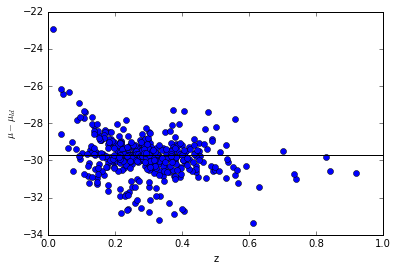

In [6]:
alpha = 0.11
beta = 3.1

from astropy.cosmology import WMAP9 as cosmo
ld = cosmo.luminosity_distance(X_test[:,3]).value 
distmod = 5.*np.log10(ld * (1e6/10.))

plt.plot(X_test[:,3],-2.5*np.log10(sample_SNe[:,0]) +alpha * sample_SNe[:,1]- beta*sample_SNe[:,2] - distmod, 'o')
plt.xlabel('z')
plt.ylabel(r'$\mu - \mu_{ld}$')
plt.axhline(-29.7, color = 'k')
#plt.savefig('empiriciSN_bias_check.pdf')


In [22]:
import sncosmo
model = sncosmo.Model(source='salt2')
magsys = sncosmo.get_magsystem('ab')

#model.set(z=0.5, x0=1.e-6, x1=0.5, c=0.2)
#params = {'z': 0.5, 'x0': 1.e-6, 'x1': 0.5, 'c': 0.2}
#model.set(**params)
#model.bandmag('bessellb', magsys, [0.])

m_B_star = []
m_B_star1 = []

for z,x0,x1,c in zip(X_test[:,3], sample_SNe[:,0], sample_SNe[:,1], sample_SNe[:,2]):
    params = {'z': z, 'x0': x0, 'x1': x1, 'c': c}
    model.set(**params)
    try:
        m_B_star.append(model.source.bandmag('bessellb', magsys, phase =[0.])[0])
    except:
        m_B_star.append(0)

for z,x0,x1,c in zip(X_test[:,3], sample_SNe[:,0], sample_SNe[:,1], sample_SNe[:,2]):
    params = {'z': z, 'x0': x0, 'x1': x1, 'c': c}
    model.set(**params)
    try: 
        m_B_star1.append(model.bandmag('bessellb', magsys,[0.])[0])
    except:
        m_B_star1.append(0)

(-25, -12)

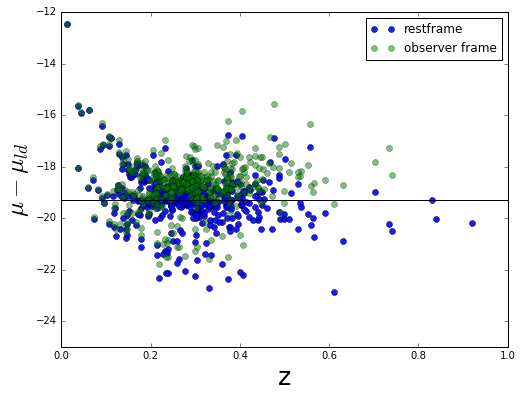

In [44]:
plt.figure(figsize = (8,6))
plt.plot(X_test[:,3], m_B_star+alpha * sample_SNe[:,1]- beta*sample_SNe[:,2] - distmod, 'o', alpha = 0.9, label = 'restframe')
plt.plot(X_test[:,3], m_B_star1+alpha * sample_SNe[:,1]- beta*sample_SNe[:,2] - distmod, 'o', alpha = 0.5, label = 'observer frame')
plt.xlabel('z', fontsize = '25')
plt.ylabel(r'$\mu - \mu_{ld}$',fontsize = '25')
plt.axhline(-19.3, color = 'k')
plt.legend()
plt.ylim(-25,-12)